In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import accuracy_score as acc
import spacy
from keras.layers import Dense, Input, Conv1D, Bidirectional, LSTM, Embedding, Dropout, concatenate
from keras.models import Model
import seaborn as sns
from keras.utils.np_utils import to_categorical

%matplotlib inline

/Users/gpp/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df = pd.read_csv("./quora_duplicate_questions.tsv", sep='\t', encoding='utf-8')
df = df[~df.question1.isnull() & ~df.question2.isnull() & ~df.is_duplicate.isnull()]
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


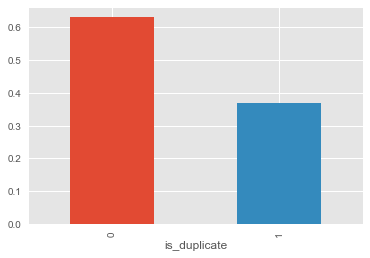

In [3]:
mpl.style.use('ggplot')
plt.xlabel("is_duplicate")
(df.is_duplicate.value_counts() / df.is_duplicate.value_counts().sum()).plot(kind='bar')

In [4]:
nlp = spacy.load("en")

In [5]:
%%time
ones = df.question1.apply(nlp)
twos = df.question2.apply(nlp)

CPU times: user 11min 5s, sys: 9.56 s, total: 11min 15s
Wall time: 11min 26s


In [6]:
import numpy as np

def get_features(docs, max_length):
    Xs = np.zeros((len(list(docs)), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        for j, token in enumerate(doc[:max_length]):
            Xs[i, j] = token.rank if token.has_vector else 0
    return Xs

def get_embeddings(vocab):
    max_rank = max(lex.rank for lex in vocab if lex.has_vector)
    vectors = np.ndarray((max_rank+1, vocab.vectors_length), dtype='float32')
    for lex in vocab:
        if lex.has_vector:
            vectors[lex.rank] = lex.vector
    return vectors

In [11]:
%%time
data1 = get_features(ones, max_length=30)
data2 = get_features(twos, max_length=30)
assert data1.shape == data2.shape

CPU times: user 20 s, sys: 6.82 s, total: 26.8 s
Wall time: 27.6 s


In [17]:
input1 = Input(shape=(30,), dtype='int32', name='one_input')
input2 = Input(shape=(30,), dtype='int32', name='two_input')

# shared embedding layer
embs = get_embeddings(nlp.vocab)
embedding_layer = Embedding(
    input_dim=embs.shape[0], output_dim=300, input_length=30, 
    trainable=False, weights=[embs], name='embedding1')

x = embedding_layer(input1)
x = Conv1D(50, 3, name='conv1')(x)
x = Bidirectional(LSTM(50, name='lstm1'), name='bidirectional_lstm1')(x)
x = Dropout(.5, name='dropout1')(x)

y = embedding_layer = Embedding(
    input_dim=embs.shape[0], output_dim=300, input_length=30, 
    trainable=False, weights=[embs], name='embedding2')(input2)
y = Conv1D(50, 3, name='conv2')(y)
y = Bidirectional(LSTM(50, name='lstm'), name='bidirectional_lstm2')(y)
y = Dropout(.5, name='dropout2')(y)

concat = concatenate([x, y])

output = Dense(2, activation='softmax', name='dense')(concat)
model = Model([input1, input2], output, name='deep_cnn_lstm')
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
one_input (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
two_input (InputLayer)          (None, 30)           0                                            
__________________________________________________________________________________________________
embedding1 (Embedding)          (None, 30, 300)      222667200   one_input[0][0]                  
__________________________________________________________________________________________________
embedding2 (Embedding)          (None, 30, 300)      222667200   two_input[0][0]                  
__________________________________________________________________________________________________
conv1 (Con

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

In [ ]:
labels = to_categorical(df.is_duplicate)
history = model.fit([data1, data2], labels, validation_split=.1, epochs=20, callbacks=[EarlyStopping(patience=2)])

Train on 363913 samples, validate on 40435 samples
Epoch 1/20
  1792/363913 [..............................] - ETA: 35:18 - loss: 0.6517 - acc: 0.6267

In [ ]:
sns.tsplot(data=history.history.get("val_acc"), time=history.epoch)